Import libraries and clean 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Visualization
from sklearn.manifold import TSNE
import seaborn as sns # tSNE visualization
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
# K-means
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/Seasons_Stats.csv')
print(df.shape)

(24691, 53)


In [3]:
def filter_years(df):
    # Filter data so only seasons from 2010 onwards are included
    df = df[df['Year'].notna()]
    df = df[df['Year'] >= 2010]
    df['Year'] = df['Year'].astype(int)
    return df

def cleaned_df(df):
    # Clean dataframe so only 1 season stat is included for every player per season
    years = df['Year'].unique()
    for year in years:
        df_year = df[df['Year'] == year]
        df_year = df_year[df_year.duplicated(subset='Player', keep=False)]
        common_rows = df['Unnamed: 0'].isin(df_year['Unnamed: 0'])
        df.drop(df[common_rows].index, inplace = True)
        df = df.append(df_year[df_year['Tm'] == 'TOT'])
    return df

def fill_empty_values(df):
    # Remove unneccesary columns and fill nulls with 0
    df.drop(columns=['Unnamed: 0', 'blanl', 'blank2'], inplace=True)
    df.drop(df[df['USG%'].isnull()].index, inplace=True)
    df.fillna(0, inplace=True)
    return df

In [4]:
df = filter_years(df)
df = cleaned_df(df)
df = fill_empty_values(df)
df.shape

(3771, 50)

In [5]:
# Taking only first position listed when multiple are listed
df['Pos'] = df['Pos'].str.split('-').str[0]

PCA Visualization

In [6]:
features = [x for x in df.columns if (x != 'Player') &  (x != 'Pos')]
print(df.shape)
print(features)

(3771, 50)
['Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [7]:
def plot_PCA(df, year):
    df_vis = df[df['Year'] == year]
    df_vis = df_vis.drop('Year', axis=1)
    features = [x for x in df_vis.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_vis.loc[:, features].values
    y = df_vis.loc[:,['Pos']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=2, random_state=0)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
    final = pd.concat([principalDf.reset_index(drop=True), df_vis['Pos'].reset_index(drop=True)], axis=1)
    print("Explained variance: ", pca.explained_variance_ratio_)
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = final.Pos.unique() # list of positions (PCA groups)
    colors = ['r', 'g', 'b', 'm', 'c']
    for target, color in zip(targets,colors):
        indicesToKeep = final['Pos'] == target
        ax.scatter(final.loc[indicesToKeep, 'pc1']
                , final.loc[indicesToKeep, 'pc2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()
    return final,pca,features

def plot_featImport_PCA(pcaObj, features):
     # feature importance for first dimension
    fimp1 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[0]})
    fimp1 = fimp1.reindex(fimp1.imp.abs().sort_values(ascending = False).index)
    top_fimp1 = fimp1.nlargest(10,'imp')
    top_fimp1 = top_fimp1.iloc[::-1]
    top_fimp1 = top_fimp1.set_index("feat")
    ax = top_fimp1.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 1 Feature Importance', fontsize = 20)

    # repeat for second dimension
    fimp2 = pd.DataFrame(data={'feat':features,'imp':pcaObj.components_[1]})
    fimp2 = fimp2.reindex(fimp2.imp.abs().sort_values(ascending = False).index)
    top_fimp2 = fimp2.nlargest(10,'imp')
    top_fimp2 = top_fimp2.iloc[::-1]
    top_fimp2 = top_fimp2.set_index("feat")
    ax = top_fimp2.plot.barh()
    ax.set_xlabel('Importance', fontsize = 15)
    ax.set_ylabel('Feature', fontsize = 15)
    ax.set_title('PCA Component 2 Feature Importance', fontsize = 20)

def feature_variance (df, year, percent):
    df_var = df[df['Year'] == year]
    df_var = df_var.drop('Year', axis=1)
    features = [x for x in df_var.columns if (x != 'Player') &  (x != 'Pos') & (x != 'Tm')]
    x = df_var.loc[:, features].values
    y = df_var.loc[:,['Pos']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=percent)
    principalComponents = pca.fit_transform(x)
    perExplained = round(100*pca.explained_variance_ratio_.sum(), 2)
    print("{}% of features explained by {} features".format(perExplained, principalComponents.shape[1]))
    return principalComponents.shape[1] # num of features
    

Explained variance:  [0.43195393 0.16785902]
99.2% of features explained by 25 features


25

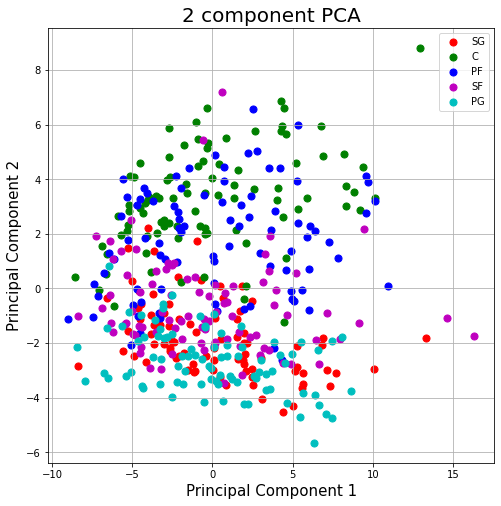

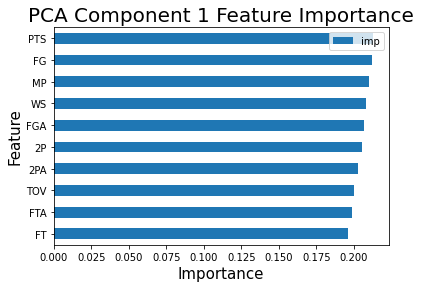

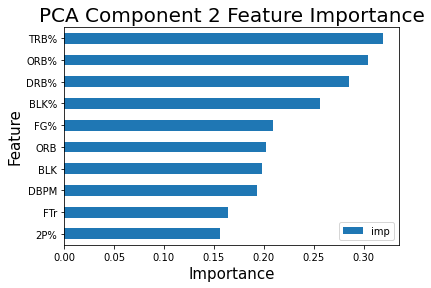

In [8]:
df_PCA, pca, features = plot_PCA(df, 2010)
# print(df_PCA.head)
plot_featImport_PCA(pca, features)

feature_variance(df, 2010, 0.99)